In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

from transport_nets.distributions import BananaFlow
tfd = tfp.distributions
tfb = tfp.bijectors

In [2]:
def make_disc_model(nn_list):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1,activation='sigmoid'))
    
    return model

def make_gen_model(nn_list,output_dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(nn_list[0]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[1]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(nn_list[2]))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(output_dim))

    return model

class T_gen(tf.keras.Model):
    
    def __init__(self,n,m,K_nn_list,F_nn_list):
        super(T_gen,self).__init__(name='T')
        self.n = n
        self.m = m
        self.K = make_gen_model(K_nn_list,n)
        self.F = make_gen_model(F_nn_list,m)
        
    def call(self, inputs):
        x = inputs[...,:self.n]
        y = inputs[...,self.n:]
        T1 = self.K(x)
        T2 = self.F(tf.concat([T1,y],axis=-1))
        
        return tf.concat([T1,T2],axis = -1)

In [3]:
# Using Adam Optimizer for minimizing the Generator and Discriminator loss
lr = 1e-5
N = 20000
BUFFER_SIZE = N
N_epochs = 200
BATCH_SIZE = 100
n = 1
m = 1
latent_dim = n+m
lamda = 0.01 # monoticity lagrange multiplier 
disc_nn_list = [200,500,100]
K_nn_list = [100,200,100]
F_nn_list = [200,500,100]

params = (0.5,0.1,0.05,0.0) #(a1,a2,a3,theta)
bFlow = BananaFlow(params)

XT = bFlow.sample(N)
x = XT[...,1:]
y = XT[...,:1]
train_dataset_tensor = tf.concat([x,y],axis=-1)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset_tensor).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

f = make_disc_model(disc_nn_list)
T = T_gen(n,m,K_nn_list,F_nn_list)

gen_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)
disc_opt = tf.keras.optimizers.Adam(learning_rate=lr, epsilon=1e-8)

def gen_loss():
    z1 = tf.random.normal([BATCH_SIZE,latent_dim])
    z2 = tf.random.normal([BATCH_SIZE,latent_dim])
    T1 = T(z1)
    T2 = T(z2)
    g_loss_fake = tf.reduce_mean(tf.math.log(f(T1)),axis=0)
    m_loss = lamda*tf.reduce_mean(tf.reduce_sum((T1-T2)*(z1-z2),axis=1))
    g_loss = g_loss_fake + m_loss
    return -g_loss

def disc_loss(x):
    z = tf.random.normal([BATCH_SIZE,latent_dim])
    d_loss_real = tf.reduce_mean(tf.math.log(f(x)),axis=0)
    d_loss_fake = tf.reduce_mean(tf.math.log(1.0-f(T(z))),axis=0)
    d_loss = d_loss_real+d_loss_fake
    return -d_loss 
    

# input x is minibatch of data points
@tf.function
def train_step(x): 
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        g_loss = gen_loss()
        d_loss = disc_loss(x)
        
    gen_grad = gen_tape.gradient(g_loss, T.trainable_variables)
    disc_grad = disc_tape.gradient(d_loss, f.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad,T.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad,f.trainable_variables))
    
    return d_loss,g_loss

def train(dataset, epochs):
    for epoch in range(epochs):
        for data_batch in dataset:
            d_loss,g_loss = train_step(data_batch)
        if epoch % 10 == 0: 
            print('it:',epoch,"D loss:",d_loss.numpy(),"G loss:",g_loss.numpy())
            
train(train_dataset,N_epochs)

it: 0 D loss: [1.3920071] G loss: [0.66844755]
it: 10 D loss: [1.3882115] G loss: [0.670804]
it: 20 D loss: [1.4081694] G loss: [0.66863567]
it: 30 D loss: [1.3858042] G loss: [0.70171666]
it: 40 D loss: [1.3893008] G loss: [0.6842377]
it: 50 D loss: [1.378467] G loss: [0.6960147]
it: 60 D loss: [1.3823658] G loss: [0.69108814]
it: 70 D loss: [1.380034] G loss: [0.70788133]
it: 80 D loss: [1.3806336] G loss: [0.6808002]
it: 90 D loss: [1.3832251] G loss: [0.67477894]
it: 100 D loss: [1.3836801] G loss: [0.68491983]
it: 110 D loss: [1.3890611] G loss: [0.68203425]
it: 120 D loss: [1.3856527] G loss: [0.68291235]
it: 130 D loss: [1.3807955] G loss: [0.68266785]
it: 140 D loss: [1.3841796] G loss: [0.6829546]
it: 150 D loss: [1.3849792] G loss: [0.679692]
it: 160 D loss: [1.3844144] G loss: [0.6927359]
it: 170 D loss: [1.3859673] G loss: [0.68412733]
it: 180 D loss: [1.3861363] G loss: [0.6842484]
it: 190 D loss: [1.3875625] G loss: [0.6973939]


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:1678: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setti

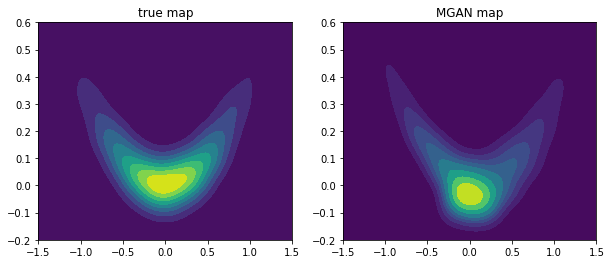

In [4]:
import seaborn as sns
def plot_density(data,axis):
    x, y = np.squeeze(np.split(data, 2, axis=1))
    return sns.kdeplot(x, y, cmap="viridis", shade=True, 
                     shade_lowest=True, ax=axis)
xa,xb,ya,yb = (-1.5,1.5,-0.2,0.6)
fig,ax = plt.subplots(1,2,figsize=(10,4))
X = bFlow.sample(5000)
X_p = T(tf.random.normal([5000,2]))
flip = tfb.Permute([1,0])
X_flipped = flip.forward(X_p)
l1 = plot_density(X,axis=ax[0])
l2 = plot_density(X_flipped,axis=ax[1])
ax[0].set(xlim=(xa,xb),ylim=(ya,yb))
ax[1].set(xlim=(xa,xb),ylim=(ya,yb))

ax[0].set_title('true map')
ax[1].set_title('MGAN map')
plt.savefig('images/MGAN_kde_final.png')

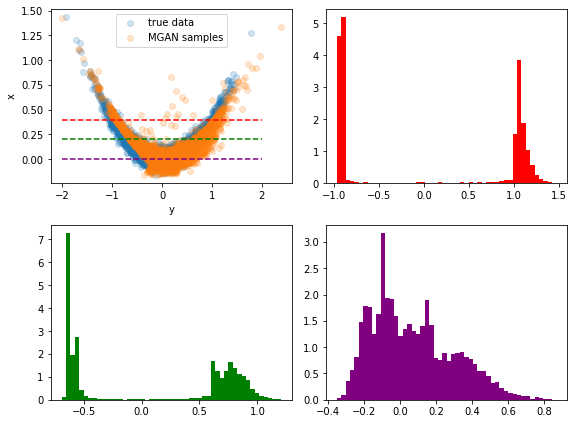

In [5]:
fig, ax = plt.subplots(2,2,figsize=(8,6))
x_obs_list = [0.4,0.2,0.0]
ax[0,0].scatter(X[:,0],X[:,1],alpha=0.2,label='true data')
ax[0,0].scatter(X_flipped[:,0],X_flipped[:,1],alpha=0.2,label='MGAN samples')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[0]*np.ones(100),'r--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[1]*np.ones(100),'g--')
ax[0,0].plot(np.linspace(-2,2,100),x_obs_list[2]*np.ones(100),'--',c='purple')
ax[0,0].set(xlabel='y',ylabel='x')
ax[0,0].legend()

Ns = 10000
u = tf.random.normal([Ns,1])

x_obs1 = x_obs_list[0]*tf.ones([Ns,1])
x_obs2 = x_obs_list[1]*tf.ones([Ns,1])
x_obs3 = x_obs_list[2]*tf.ones([Ns,1])
y_sample1 = T.F(tf.concat([x_obs1,u],axis=-1))[...,0].numpy()
y_sample2 = T.F(tf.concat([x_obs2,u],axis=-1))[...,0].numpy()
y_sample3 = T.F(tf.concat([x_obs3,u],axis=-1))[...,0].numpy()
ax[0,1].hist(y_sample1,50,color='r',density=True)
ax[1,0].hist(y_sample2,50,color='g',density=True)
ax[1,1].hist(y_sample3,50,color='purple',density=True)
plt.tight_layout()
plt.savefig('images/MGAN_conditional_samples.png')

In [6]:
T.summary()

Model: "T"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1)                 42201     
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 154501    
Total params: 196,702
Trainable params: 194,302
Non-trainable params: 2,400
_________________________________________________________________
